In [1]:
import pandas as pd
import numpy as np

In [2]:
import openml
#openml.config.apikey = 'FILL_IN_OPENML_API_KEY'  # set the OpenML Api Key
SUITE_ID = 336 # Regression on numerical features
#SUITE_ID = 337 # Classification on numerical features
#SUITE_ID = 335 # Regression on numerical and categorical features
#SUITE_ID = 334 # Classification on numerical and categorical features
benchmark_suite = openml.study.get_suite(SUITE_ID)  # obtain the benchmark suite

In [4]:
task = openml.tasks.get_task(361072)  # download the OpenML task
dataset = task.get_dataset()

c:\Users\dalma\AppData\Local\Programs\Python\Python310\lib\site-packages\openml\tasks\functions.py:372: FutureWarning: Starting from Version 0.15.0 `download_splits` will default to ``False`` instead of ``True`` and be independent from `download_data`. To disable this message until version 0.15 explicitly set `download_splits` to a bool.
  warnings.warn(
c:\Users\dalma\AppData\Local\Programs\Python\Python310\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(


In [5]:
dataset

OpenML Dataset
Name..........: cpu_act
Version.......: 8
Format........: arff
Upload Date...: 2022-07-05 20:47:51
Licence.......: Public
Download URL..: https://api.openml.org/data/v1/download/22103257/cpu_act.arff
OpenML URL....: https://www.openml.org/d/44132
# of features.: 22
# of instances: 8192

In [6]:
X, y, categorical_indicator, attribute_names = dataset.get_data(
        dataset_format="dataframe", target=dataset.default_target_attribute)

In [82]:
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from hpsklearn import HyperoptEstimator
from hpsklearn import any_regressor
from hpsklearn import any_preprocessing

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [83]:
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=22)

In [33]:
from sklearn.linear_model import LinearRegression 
import lightgbm as lgbm

In [73]:
lin_reg=LinearRegression()
lin_reg.fit(X_train, y_train)
y_test_hat_linreg=lin_reg.predict(X_test)
RMSE_linreg=np.sqrt(np.mean((y_test-y_test_hat_linreg))**2)

boosted_tree_model=lgbm.LGBMRegressor()
boosted_tree_model.fit(X_train, y_train)
y_test_hat_boost=boosted_tree_model.predict(X_test)
RMSE_boost=np.sqrt(np.mean((y_test-y_test_hat_boost))**2)

rf=lgbm.LGBMRegressor(boosting_type="rf", subsample_freq=1, subsample=0.5)
rf.fit(X_train, y_train)
y_test_hat_rf=rf.predict(X_test)
RMSE_rf=np.sqrt(np.mean((y_test-y_test_hat_rf))**2)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4853
[LightGBM] [Info] Number of data points in the train set: 6553, number of used features: 21
[LightGBM] [Info] Start training from score 84.025790
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4853
[LightGBM] [Info] Number of data points in the train set: 6553, number of used features: 21
[LightGBM] [Info] Start training from score 84.025790


In [74]:
print(RMSE_linreg)
print(RMSE_boost)
print(RMSE_rf)

0.11346621438751542
0.023893443004829713
0.059410165217422935


In [96]:
import optuna


def boosted(trial):

    params = {'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
              'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
              'max_depth': trial.suggest_int('max_depth', 1, 30),
              #'num_leaves': trial.suggest_int('num_leaves', 2, 100),
              'min_child_samples': trial.suggest_int('min_child_samples', 10, 100)}
    
    boosted_tree_model=lgbm.LGBMRegressor(**params)
    boosted_tree_model.fit(X_train_, y_train_)
    y_val_hat_boost=boosted_tree_model.predict(X_val)
    RMSE_boost=np.sqrt(np.mean((y_val-y_val_hat_boost))**2)

    return RMSE_boost

sampler = optuna.samplers.TPESampler(seed=10)
study = optuna.create_study(sampler=sampler, direction='minimize')
study.optimize(boosted, n_trials=10)

boosted_model=lgbm.LGBMRegressor(**study.best_params)


def boosted(trial):

    params = {'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
              'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
              'max_depth': trial.suggest_int('max_depth', 1, 30),
              #'num_leaves': trial.suggest_int('num_leaves', 2, 100),
              'min_child_samples': trial.suggest_int('min_child_samples', 10, 100)}
    
    boosted_tree_model=lgbm.LGBMRegressor(**params)
    boosted_tree_model.fit(X_train_, y_train_)
    y_val_hat_boost=boosted_tree_model.predict(X_val)
    RMSE_boost=np.sqrt(np.mean((y_val-y_val_hat_boost))**2)

    return RMSE_boost

sampler = optuna.samplers.TPESampler(seed=10)
study = optuna.create_study(sampler=sampler, direction='minimize')
study.optimize(boosted, n_trials=10)

boosted_model=lgbm.LGBMRegressor(**study.best_params)

[I 2023-12-01 18:22:39,677] A new study created in memory with name: no-name-e55adffb-0af4-4dc3-962d-c559e45b3c56
[I 2023-12-01 18:22:39,856] Trial 0 finished with value: 0.07645441916241363 and parameters: {'learning_rate': 0.3879471152007055, 'reg_lambda': 1.537331564587801e-08, 'max_depth': 20, 'min_child_samples': 78}. Best is trial 0 with value: 0.07645441916241363.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

[I 2023-12-01 18:22:39,989] Trial 1 finished with value: 0.07715370419782382 and parameters: {'learning_rate': 0.2542684360282693, 'reg_lambda': 1.0547992438188775e-06, 'max_depth': 6, 'min_child_samples': 79}. Best is trial 0 with value: 0.07645441916241363.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-12-01 18:22:40,141] Trial 2 finished with value: 0.06273914299447474 and parameters: {'learning_rate': 0.09286430991564236, 'reg_lambda': 6.238186113062485e-08, 'max_depth': 21, 'min_child_samples': 96}. Best is trial 2 with value: 0.06273914299447474.
[I 2023-12-01 18:22:40,290] Trial 3 finished with value: 0.08182313435194251 and parameters: {'learning_rate': 0.011934650500678082, 'reg_lambda': 0.0004071274363191098, 'max_depth': 25, 'min_child_samples': 65}. Best is trial 2 with value: 0.06273914299447474.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-12-01 18:22:40,408] Trial 4 finished with value: 0.06407551628125277 and parameters: {'learning_rate': 0.3636601055415818, 'reg_lambda': 4.235304245072407e-06, 'max_depth': 28, 'min_child_samples': 75}. Best is trial 2 with value: 0.06273914299447474.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

[I 2023-12-01 18:22:40,525] Trial 5 finished with value: 0.05473747974342514 and parameters: {'learning_rate': 0.27584674032551804, 'reg_lambda': 1.9034015928564192e-07, 'max_depth': 12, 'min_child_samples': 71}. Best is trial 5 with value: 0.05473747974342514.
[I 2023-12-01 18:22:40,648] Trial 6 finished with value: 0.04526480738855055 and parameters: {'learning_rate': 0.2264982554672681, 'reg_lambda': 8.056120247993029e-05, 'max_depth': 19, 'min_child_samples': 56}. Best is trial 6 with value: 0.04526480738855055.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-12-01 18:22:40,777] Trial 7 finished with value: 0.030392082826789756 and parameters: {'learning_rate': 0.32869461914641895, 'reg_lambda': 0.0025665550309028774, 'max_depth': 25, 'min_child_samples': 57}. Best is trial 7 with value: 0.030392082826789756.
[I 2023-12-01 18:22:40,826] Trial 8 finished with value: 0.10098310073038085 and parameters: {'learning_rate': 0.4552379515962474, 'reg_lambda': 7.4666329224550155e-06, 'max_depth': 3, 'min_child_samples': 37}. Best is trial 7 with value: 0.030392082826789756.
[I 2023-12-01 18:22:40,867] Trial 9 finished with value: 0.08410339589672867 and parameters: {'learning_rate': 0.06585233731313939, 'reg_lambda': 0.2871652845130526, 'max_depth': 2, 'min_child_samples': 66}. Best is trial 7 with value: 0.030392082826789756.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

{'learning_rate': 0.32869461914641895,
 'reg_lambda': 0.0025665550309028774,
 'max_depth': 25,
 'min_child_samples': 57}

In [86]:
study

#### Look at the difference when using Mahalanobis distance

In [136]:
import numpy as np
from scipy.spatial.distance import mahalanobis

# calculate the mean and covariance matrix of the dataset
mean = np.mean(X, axis=0)
cov = np.cov(X.T)

# calculate the Mahalanobis distance for each data point
mahalanobis_dist = [mahalanobis(x, mean, np.linalg.inv(cov)) for x in X.values]

In [137]:
mahalanobis_dist=pd.Series(mahalanobis_dist,index=X.index)
far_index=mahalanobis_dist.index[np.where(mahalanobis_dist>=np.quantile(mahalanobis_dist,0.8))[0]]
close_index=mahalanobis_dist.index[np.where(mahalanobis_dist<np.quantile(mahalanobis_dist,0.8))[0]]

In [138]:
X_train = X.loc[close_index,:]
X_test = X.loc[far_index,:]
y_train = y.loc[close_index]
y_test = y.loc[far_index]

In [139]:
mean = np.mean(X_train, axis=0)
cov = np.cov(X_train.T)

# calculate the Mahalanobis distance for each data point
mahalanobis_dist_ = [mahalanobis(x, mean, np.linalg.inv(cov)) for x in X_train.values]

mahalanobis_dist_=pd.Series(mahalanobis_dist_,index=X_train.index)
far_index_=mahalanobis_dist_.index[np.where(mahalanobis_dist_>=np.quantile(mahalanobis_dist_,0.8))[0]]
close_index_=mahalanobis_dist_.index[np.where(mahalanobis_dist_<np.quantile(mahalanobis_dist_,0.8))[0]]

X_train_ = X_train.loc[close_index_,:]
X_val = X_train.loc[far_index_,:]
y_train_ = y_train.loc[close_index_]
y_val = y_train.loc[far_index_]

In [142]:
import optuna
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
N_TRIALS=10

def gp(trial):

    params = {'lenghtscale': trial.suggest_float('lenghtscale', 0, 10)}
    
    gp=GaussianProcessRegressor(kernel=Matern(length_scale=params['lenghtscale'], nu=1.5))
    gp.fit(X_train_, y_train_)
    y_val_hat_gp=gp.predict(X_val)
    RMSE_gp=np.sqrt(np.mean((y_val-y_val_hat_gp)**2))
    return RMSE_gp

sampler_gp = optuna.samplers.TPESampler(seed=10)
study_gp = optuna.create_study(sampler=sampler_gp, direction='minimize')
study_gp.optimize(gp, n_trials=N_TRIALS)

gp_model=GaussianProcessRegressor(kernel=Matern(length_scale=study_gp.best_params['lenghtscale'], nu=1.5))


def boosted(trial):

    params = {'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
              'n_estimators': trial.suggest_int('n_estimators', 100, 500),
              'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
              'max_depth': trial.suggest_int('max_depth', 1, 30),
              #'num_leaves': trial.suggest_int('num_leaves', 2, 100),
              'min_child_samples': trial.suggest_int('min_child_samples', 10, 100)}
    
    boosted_tree_model=lgbm.LGBMRegressor(**params)
    boosted_tree_model.fit(X_train_, y_train_)
    y_val_hat_boost=boosted_tree_model.predict(X_val)
    RMSE_boost=np.sqrt(np.mean((y_val-y_val_hat_boost)**2))

    return RMSE_boost

sampler_boost = optuna.samplers.TPESampler(seed=10)
study_boost = optuna.create_study(sampler=sampler_boost, direction='minimize')
study_boost.optimize(boosted, n_trials=N_TRIALS)

boosted_model=lgbm.LGBMRegressor(**study_boost.best_params)


def rf(trial):

    params = {'boosting_type':"rf",
              'n_estimators': trial.suggest_int('n_estimators', 100, 500),
              'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
              'max_depth': trial.suggest_int('max_depth', 1, 30),
              'subsample_freq': trial.suggest_int('subsample_freq', 1, 10),
              'subsample': trial.suggest_float('subsample', 0.5, 1),
              #'num_leaves': trial.suggest_int('num_leaves', 2, 100),
              'min_child_samples': trial.suggest_int('min_child_samples', 10, 100)}
    
    rf_model=lgbm.LGBMRegressor(**params)
    rf_model.fit(X_train_, y_train_)
    y_val_hat_rf=rf_model.predict(X_val)
    RMSE_rf=np.sqrt(np.mean((y_val-y_val_hat_rf)**2))

    return RMSE_rf

sampler_rf = optuna.samplers.TPESampler(seed=10)
study_rf = optuna.create_study(sampler=sampler_rf, direction='minimize')
study_rf.optimize(rf, n_trials=N_TRIALS)

rf_model=lgbm.LGBMRegressor(**study_rf.best_params)

[I 2023-12-04 10:46:33,251] A new study created in memory with name: no-name-58356da7-33ad-49d2-b3f6-1e494bc2f549
[I 2023-12-04 10:49:40,006] Trial 0 finished with value: 18.320949842839397 and parameters: {'lenghtscale': 7.71320643266746}. Best is trial 0 with value: 18.320949842839397.
[I 2023-12-04 10:50:09,981] Trial 1 finished with value: 77.15865751334859 and parameters: {'lenghtscale': 0.207519493594015}. Best is trial 0 with value: 18.320949842839397.
[I 2023-12-04 10:54:18,896] Trial 2 finished with value: 18.320949841533366 and parameters: {'lenghtscale': 6.336482349262754}. Best is trial 2 with value: 18.320949841533366.
[I 2023-12-04 11:02:42,473] Trial 3 finished with value: 18.320951111080884 and parameters: {'lenghtscale': 7.488038825386118}. Best is trial 2 with value: 18.320949841533366.
[I 2023-12-04 11:10:54,250] Trial 4 finished with value: 18.321006223368716 and parameters: {'lenghtscale': 4.9850701230259045}. Best is trial 2 with value: 18.320949841533366.
[I 2023

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3766
[LightGBM] [Info] Number of data points in the train set: 5242, number of used features: 21
[LightGBM] [Info] Start training from score 91.111980


[I 2023-12-04 11:15:50,794] Trial 0 finished with value: 6.548774458745064 and parameters: {'learning_rate': 0.3879471152007055, 'n_estimators': 108, 'reg_lambda': 0.005044685709888605, 'max_depth': 23, 'min_child_samples': 55}. Best is trial 0 with value: 6.548774458745064.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3766
[LightGBM] [Info] Number of data points in the train set: 5242, number of used features: 21
[LightGBM] [Info] Start training from score 91.111980
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

[I 2023-12-04 11:15:50,985] Trial 1 finished with value: 6.419385988876968 and parameters: {'learning_rate': 0.12015035631011535, 'n_estimators': 179, 'reg_lambda': 0.0699481785242808, 'max_depth': 6, 'min_child_samples': 18}. Best is trial 1 with value: 6.419385988876968.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3766
[LightGBM] [Info] Number of data points in the train set: 5242, number of used features: 21
[LightGBM] [Info] Start training from score 91.111980
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

[I 2023-12-04 11:15:51,556] Trial 2 finished with value: 6.536407589304645 and parameters: {'learning_rate': 0.34582631100022065, 'n_estimators': 482, 'reg_lambda': 1.08526150100961e-08, 'max_depth': 16, 'min_child_samples': 83}. Best is trial 1 with value: 6.419385988876968.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-12-04 11:15:52,075] Trial 3 finished with value: 6.657181105841132 and parameters: {'learning_rate': 0.3101377727464002, 'n_estimators': 389, 'reg_lambda': 4.235304245072407e-06, 'max_depth': 28, 'min_child_samples': 75}. Best is trial 1 with value: 6.419385988876968.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3766
[LightGBM] [Info] Number of data points in the train set: 5242, number of used features: 21
[LightGBM] [Info] Start training from score 91.111980


[I 2023-12-04 11:15:52,300] Trial 4 finished with value: 6.5263899496196025 and parameters: {'learning_rate': 0.27584674032551804, 'n_estimators': 157, 'reg_lambda': 2.2912202578440842e-05, 'max_depth': 21, 'min_child_samples': 50}. Best is trial 1 with value: 6.419385988876968.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3766
[LightGBM] [Info] Number of data points in the train set: 5242, number of used features: 21
[LightGBM] [Info] Start training from score 91.111980
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

[I 2023-12-04 11:15:52,753] Trial 5 finished with value: 6.556287617886695 and parameters: {'learning_rate': 0.22266685673331393, 'n_estimators': 347, 'reg_lambda': 0.0004151874170225355, 'max_depth': 20, 'min_child_samples': 64}. Best is trial 1 with value: 6.419385988876968.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3766
[LightGBM] [Info] Number of data points in the train set: 5242, number of used features: 21
[LightGBM] [Info] Start training from score 91.111980
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

[I 2023-12-04 11:15:53,218] Trial 6 finished with value: 6.391910326154809 and parameters: {'learning_rate': 0.40455936644804574, 'n_estimators': 309, 'reg_lambda': 1.5060518616773197, 'max_depth': 10, 'min_child_samples': 18}. Best is trial 6 with value: 6.391910326154809.
[I 2023-12-04 11:15:53,275] Trial 7 finished with value: 6.855905014952471 and parameters: {'learning_rate': 0.15734302775173967, 'n_estimators': 145, 'reg_lambda': 0.2871652845130526, 'max_depth': 2, 'min_child_samples': 66}. Best is trial 6 with value: 6.391910326154809.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3766
[LightGBM] [Info] Number of data points in the train set: 5242, number of used features: 21
[LightGBM] [Info] Start training from score 91.111980
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

[I 2023-12-04 11:15:53,783] Trial 8 finished with value: 6.553463831834591 and parameters: {'learning_rate': 0.27831721640042933, 'n_estimators': 428, 'reg_lambda': 6.173448891970491e-07, 'max_depth': 26, 'min_child_samples': 42}. Best is trial 6 with value: 6.391910326154809.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3766
[LightGBM] [Info] Number of data points in the train set: 5242, number of used features: 21
[LightGBM] [Info] Start training from score 91.111980
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

[I 2023-12-04 11:15:54,041] Trial 9 finished with value: 6.607179212431153 and parameters: {'learning_rate': 0.37977736884963004, 'n_estimators': 218, 'reg_lambda': 0.9024607364578421, 'max_depth': 10, 'min_child_samples': 25}. Best is trial 6 with value: 6.391910326154809.
[I 2023-12-04 11:15:54,057] A new study created in memory with name: no-name-63af5c07-1fac-4a13-a198-41201059cbc4


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was

[I 2023-12-04 11:15:54,894] Trial 0 finished with value: 7.902924394262695 and parameters: {'n_estimators': 409, 'reg_lambda': 1.537331564587801e-08, 'max_depth': 20, 'subsample_freq': 8, 'subsample': 0.7492535061512953, 'min_child_samples': 30}. Best is trial 0 with value: 7.902924394262695.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3766
[LightGBM] [Info] Number of data points in the train set: 5242, number of used features: 21
[LightGBM] [Info] Start training from score 91.111980
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

[I 2023-12-04 11:15:55,191] Trial 1 finished with value: 8.1667682993641 and parameters: {'n_estimators': 179, 'reg_lambda': 0.0699481785242808, 'max_depth': 6, 'subsample_freq': 1, 'subsample': 0.8426799091838986, 'min_child_samples': 96}. Best is trial 0 with value: 7.902924394262695.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM]

[I 2023-12-04 11:15:55,367] Trial 2 finished with value: 7.997044966912059 and parameters: {'n_estimators': 101, 'reg_lambda': 0.0004071274363191098, 'max_depth': 25, 'subsample_freq': 7, 'subsample': 0.8608776587158997, 'min_child_samples': 36}. Best is trial 0 with value: 7.902924394262695.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3766
[LightGBM] [Info] Number of data points in the train set: 5242, number of used features: 21
[LightGBM] [Info] Start training from score 91.111980


[I 2023-12-04 11:15:56,087] Trial 3 finished with value: 8.109009403219488 and parameters: {'n_estimators': 468, 'reg_lambda': 0.02698870526662559, 'max_depth': 17, 'subsample_freq': 2, 'subsample': 0.6866703800257346, 'min_child_samples': 71}. Best is trial 0 with value: 7.902924394262695.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3766
[LightGBM] [Info] Number of data points in the train set: 5242, number of used features: 21
[LightGBM] [Info] Start training from score 91.111980


[I 2023-12-04 11:15:56,457] Trial 4 finished with value: 8.019792959551717 and parameters: {'n_estimators': 277, 'reg_lambda': 8.056120247993029e-05, 'max_depth': 19, 'subsample_freq': 6, 'subsample': 0.8251985909657336, 'min_child_samples': 64}. Best is trial 0 with value: 7.902924394262695.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3766
[LightGBM] [Info] Number of data points in the train set: 5242, number of used features: 21
[LightGBM] [Info] Start training from score 91.111980


[I 2023-12-04 11:15:57,109] Trial 5 finished with value: 8.0104005724075 and parameters: {'n_estimators': 422, 'reg_lambda': 0.0004952498715186091, 'max_depth': 28, 'subsample_freq': 4, 'subsample': 0.5452296746354537, 'min_child_samples': 37}. Best is trial 0 with value: 7.902924394262695.
[I 2023-12-04 11:15:57,181] Trial 6 finished with value: 9.238879152045008 and parameters: {'n_estimators': 145, 'reg_lambda': 0.2871652845130526, 'max_depth': 2, 'subsample_freq': 7, 'subsample': 0.7737930779596218, 'min_child_samples': 84}. Best is trial 0 with value: 7.902924394262695.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3766
[LightGBM] [Info] Number of data points in the train set: 5242, number of used features: 21
[LightGBM] [Info] Start training from score 91.111980
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3766
[LightGBM] [Info] Number of data points in the train set: 5242, number o

[I 2023-12-04 11:15:57,375] Trial 7 finished with value: 8.273070816054899 and parameters: {'n_estimators': 179, 'reg_lambda': 0.5148168134404182, 'max_depth': 11, 'subsample_freq': 8, 'subsample': 0.6479808534398394, 'min_child_samples': 90}. Best is trial 0 with value: 7.902924394262695.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-12-04 11:15:57,818] Trial 8 finished with value: 7.927649663794281 and parameters: {'n_estimators': 230, 'reg_lambda': 3.055927730910031e-07, 'max_depth': 12, 'subsample_freq': 1, 'subsample': 0.9105528289184642, 'min_child_samples': 23}. Best is trial 0 with value: 7.902924394262695.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3766
[LightGBM] [Info] Number of data points in the train set: 5242, number of used features: 21
[LightGBM] [Info] Start training from score 91.111980


[I 2023-12-04 11:15:58,269] Trial 9 finished with value: 8.310839394080224 and parameters: {'n_estimators': 254, 'reg_lambda': 3.15026008204159, 'max_depth': 30, 'subsample_freq': 5, 'subsample': 0.91306142192137, 'min_child_samples': 32}. Best is trial 0 with value: 7.902924394262695.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [167]:
gp_model.fit(X_train, y_train)
y_test_hat_gp=gp_model.predict(X_test)
RMSE_gp=np.sqrt(np.mean((y_test-y_test_hat_gp)**2))

boosted_model.fit(X_train, y_train)
y_test_hat_boosted=boosted_model.predict(X_test)
RMSE_boosted=np.sqrt(np.mean((y_test-y_test_hat_boosted)**2))

rf_model.fit(X_train, y_train)
y_test_hat_rf=rf_model.predict(X_test)
RMSE_rf=np.sqrt(np.mean((y_test-y_test_hat_rf)**2))

lin_reg=LinearRegression()
lin_reg.fit(X_train, y_train)
y_test_hat_linreg=lin_reg.predict(X_test)
RMSE_linreg=np.sqrt(np.mean((y_test-y_test_hat_linreg)**2))

print("RMSE linear regression: ",RMSE_linreg)
print("RMSE boosted trees", RMSE_boost)
print("RMSE random forest", RMSE_rf)
print("RMSE gaussian process", RMSE_gp)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4351
[LightGBM] [Info] Number of data points in the train set: 6553, number of used features: 21
[LightGBM] [Info] Start training from score 88.320464
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

In [206]:
from depth.multivariate import *

ModuleNotFoundError: No module named 'depth.multivariate'

In [218]:
from statdepth import FunctionalDepth, PointcloudDepth

In [225]:
bd = FunctionalDepth(list(np.array(X)), containment='simplex', relax=True, quiet=False)

IndexError: tuple index out of range

In [ ]:
gp_model=GaussianProcessRegressor(kernel=Matern(length_scale=study_gp.best_params['lenghtscale'], nu=1.5))
boosted_model=lgbm.LGBMRegressor(**study_boost.best_params)
rf_model=lgbm.LGBMRegressor(**study_rf.best_params)




engressor = engression(torch.Tensor(np.array(X_train)), torch.Tensor(np.array(y_train).reshape(-1,1)), lr=0.01, num_epoches=500, batch_size=1000)

In [214]:
#### Try to use simplicial data depth instead
#import depth
dist_simplical=depth.multivariate.simplicial(X, X,)


AttributeError: module 'depth' has no attribute 'multivariate'

In [153]:
import torch

In [155]:
from engression import engression
## Fit an engression model
engressor = engression(torch.Tensor(np.array(X_train)), torch.Tensor(np.array(y_train).reshape(-1,1)), lr=0.01, num_epoches=500, batch_size=1000)
## Summarize model information
engressor.summary()

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Training based on mini-batch gradient descent with a batch size of 1000.
[Epoch 1 (0%), batch 7] energy-loss: 0.1461,  E(|Y-Yhat|): 0.4062,  E(|Yhat-Yhat'|): 0.5202
[Epoch 100 (20%), batch 7] energy-loss: 0.1116,  E(|Y-Yhat|): 0.2282,  E(|Yhat-Yhat'|): 0.2333
[Epoch 200 (40%), batch 7] energy-loss: 0.1036,  E(|Y-Yhat|): 0.2071,  E(|Yhat-Yhat'|): 0.2070
[Epoch 300 (60%), batch 7] energy-loss: 0.0965,  E(|Y-Yhat|): 0.2011,  E(|Yhat-Yhat'|): 0.2090
[Epoch 400 (80%), batch 7] energy-loss: 0.0979,  E(|Y-Yhat|): 0.1921,  E(|Yhat-Yhat'|): 0.1884
[Epoch 500 (100%), batch 7] energy-loss: 0.0950,  E(|Y-Yhat|): 0.1873,  E(|Yhat-Yhat'|): 0.1845

Training loss on the original (non-standardized) scale:
	Energy-loss: 1.0691,  E(|Y-Yhat|): 2.2431,  E(|Yhat-Yhat'|): 2.3479

Predictio

In [178]:
y_test_hat_engression=engressor.predict(torch.Tensor(np.array(X_test)), target="mean")
RMSE_engression=np.sqrt((((torch.Tensor(np.array(y_test).reshape(-1,1)))-y_test_hat_engression)**2).mean(axis=0))

print("RMSE engression: ", np.array(RMSE_engression))

RMSE engression:  [10.225099]


In [179]:
## Fit a bagged engression model
from engression import engression_bagged
engressor_bagged = engression_bagged(torch.Tensor(np.array(X_train)), torch.Tensor(np.array(y_train).reshape(-1,1)), lr=0.01, num_epoches=500, batch_size=1000)
## Summarize model information
engressor_bagged.summary()

Running on CPU.

Model 1 training details:

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Training based on mini-batch gradient descent with a batch size of 1000.
[Epoch 1 (0%), batch 4] energy-loss: 0.2891,  E(|Y-Yhat|): 0.6057,  E(|Yhat-Yhat'|): 0.6331
[Epoch 100 (20%), batch 4] energy-loss: 0.1226,  E(|Y-Yhat|): 0.2563,  E(|Yhat-Yhat'|): 0.2673
[Epoch 200 (40%), batch 4] energy-loss: 0.1016,  E(|Y-Yhat|): 0.2203,  E(|Yhat-Yhat'|): 0.2373
[Epoch 300 (60%), batch 4] energy-loss: 0.0807,  E(|Y-Yhat|): 0.1956,  E(|Yhat-Yhat'|): 0.2299
[Epoch 400 (80%), batch 4] energy-loss: 0.0936,  E(|Y-Yhat|): 0.2121,  E(|Yhat-Yhat'|): 0.2368
[Epoch 500 (100%), batch 4] energy-loss: 0.0886,  E(|Y-Yhat|): 0.1997,  E(|Yhat-Yhat'|): 0.2222

Training loss on the original (non-standardized) scale:
	Energy-loss: 1.0920,  E(|Y-Yhat|): 2.2789,  E(|Yhat

In [180]:
y_test_hat_engression_bagged=engressor_bagged.predict(torch.Tensor(np.array(X_test)), target="mean")
RMSE_engression_bagged=np.sqrt((((torch.Tensor(np.array(y_test).reshape(-1,1)))-y_test_hat_engression_bagged)**2).mean(axis=0))

print("RMSE engression bagged: ", np.array(RMSE_engression_bagged))

RMSE engression bagged:  [5.657687]


In [193]:
import pygam
gam=pygam.LinearGAM()

In [195]:
gam.fit(X_train,y_train)
y_test_hat_gam=gam.predict(X_test)
RMSE_gam=np.sqrt(np.mean((y_test-y_test_hat_gam)**2))

print("RMSE gam: ",RMSE_gam)

RMSE gam:  26.588899789636343


In [165]:
print(y_test_hat_engression.shape)
print((torch.Tensor(np.array(y_test).reshape(-1,1))).shape)

torch.Size([1639, 1])
torch.Size([1639, 1])


In [146]:
X_train.shape

(6553, 21)

In [149]:
(np.array(y_train).reshape(-1,1)).shape

(6553, 1)

In [79]:
lin_reg=LinearRegression()
lin_reg.fit(X_train, y_train)
y_test_hat_linreg=lin_reg.predict(X_test)
RMSE_linreg=np.sqrt(np.mean((y_test-y_test_hat_linreg))**2)

boosted_tree_model=lgbm.LGBMRegressor()
boosted_tree_model.fit(X_train, y_train)
y_test_hat_boost=boosted_tree_model.predict(X_test)
RMSE_boost=np.sqrt(np.mean((y_test-y_test_hat_boost))**2)

rf=lgbm.LGBMRegressor(boosting_type="rf", subsample_freq=1, subsample=0.5)
rf.fit(X_train, y_train)
y_test_hat_rf=rf.predict(X_test)
RMSE_rf=np.sqrt(np.mean((y_test-y_test_hat_rf))**2)
print(RMSE_linreg)
print(RMSE_boost)
print(RMSE_rf)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4351
[LightGBM] [Info] Number of data points in the train set: 6553, number of used features: 21
[LightGBM] [Info] Start training from score 88.320464
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4351
[LightGBM] [Info] Number of data points in the train set: 6553, number of used features: 21
[LightGBM] [Info] Start training from score 88.320464
11.097427194996309
2.2270184840127323
3.9921802093936547


In [128]:
y_train_hat_boost=boosted_tree_model.predict(X_train)
RMSE_boost_train=np.sqrt(np.mean((y_train-y_train_hat_boost))**2)
print(RMSE_boost_train)

1.2753891877527628e-10


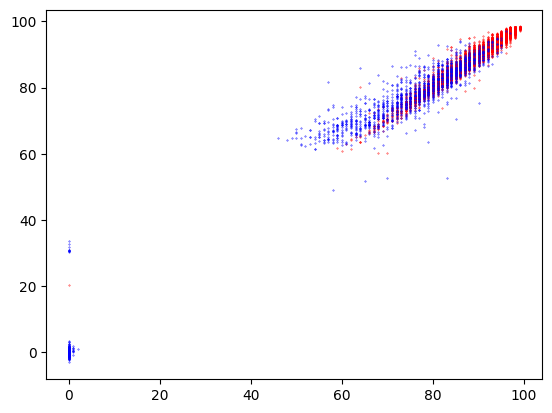

In [129]:
import matplotlib.pyplot as plt
plt.scatter(y_train, y_train_hat_boost, c='r', s=0.1)
plt.scatter(y_test, y_test_hat_boost, c='b', s=0.1)
plt.show()

In [130]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
x_pca_train = X_train.loc[:, ].values
x_pca_train = StandardScaler().fit_transform(x_pca_train) # normalizing the features
pca_train = PCA(n_components=2)
principalComponents_train = pca_train.fit_transform(x_pca_train)

x_pca_test = X_test.loc[:, ].values
x_pca_test = StandardScaler().fit_transform(x_pca_test) # normalizing the features
pca_test = PCA(n_components=2)
principalComponents_test = pca_test.fit_transform(x_pca_test)

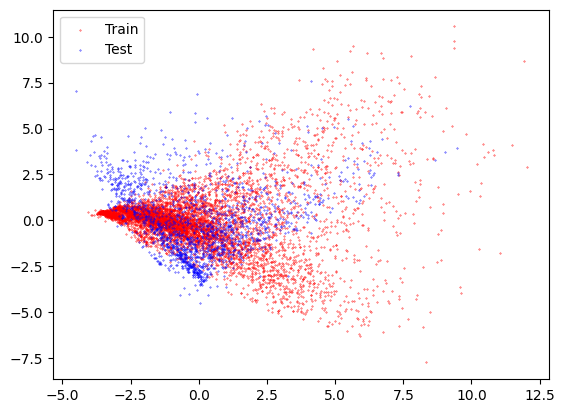

In [135]:
plt.scatter(principalComponents_train[:,0],principalComponents_train[:,1],c='r',s=0.1)
plt.scatter(principalComponents_test[:,0],principalComponents_test[:,1],c='b',s=0.1)
plt.legend(["Train","Test"])
plt.show()

In [70]:
from hyperopt import tpe
model = HyperoptEstimator(regressor=any_regressor('reg'), preprocessing=any_preprocessing('pre'), algo=tpe.suggest, loss_fn=mean_absolute_error, max_evals=5, rstate=np.random.default_rng(3))
# perform the search
model.fit(X_train, y_train)
# summarize performance
mae = model.score(X_test, y_test)

TypeError: hyperopt_estimator.__init__() got an unexpected keyword argument 'rstate'

In [10]:
from hpsklearn import HyperoptEstimator


WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


In [12]:
import hyperopt

In [8]:
categorical_indicator

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [6]:
import openml
#openml.config.apikey = 'FILL_IN_OPENML_API_KEY'  # set the OpenML Api Key
SUITE_ID = 336 # Regression on numerical features
#SUITE_ID = 337 # Classification on numerical features
#SUITE_ID = 335 # Regression on numerical and categorical features
#SUITE_ID = 334 # Classification on numerical and categorical features
benchmark_suite = openml.study.get_suite(SUITE_ID)  # obtain the benchmark suite
for task_id in benchmark_suite.tasks:  # iterate over all tasks
    task = openml.tasks.get_task(task_id)  # download the OpenML task
    dataset = task.get_dataset()
    X, y, categorical_indicator, attribute_names = dataset.get_data(
        dataset_format="dataframe", target=dataset.default_target_attribute
    )

c:\Users\dalma\AppData\Local\Programs\Python\Python310\lib\site-packages\openml\tasks\functions.py:372: FutureWarning: Starting from Version 0.15.0 `download_splits` will default to ``False`` instead of ``True`` and be independent from `download_data`. To disable this message until version 0.15 explicitly set `download_splits` to a bool.
  warnings.warn(
c:\Users\dalma\AppData\Local\Programs\Python\Python310\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
c:\Users\dalma\AppData\Local\Programs\Python\Python310\lib\site-packages\openml\tasks\functions.py:372: FutureWarning: Starting from Version 0.15.0 `download

KeyboardInterrupt: 